In [ ]:
from ocr.core import *
import cv2
from fastai import *
from fastai.vision import *
from tqdm.notebook import tqdm

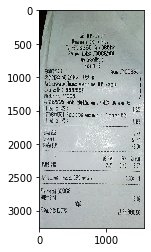

In [ ]:
im = cv2.imread('../test_data/cekis_cropped.jpg')
im = im[ :, :, [2,1,0] ] # BGR -> RGB
plot(im)

In [ ]:
from ocr.bbox_east_training import *
from ocr.bbox_east_inference import TextBBoxPredictor, show_bboxes_on_image
bbox_predictor = TextBBoxPredictor(model_name='east_bbox_10x3', use_gpu=False)

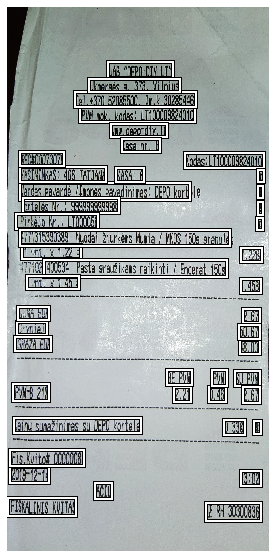

In [ ]:
bboxes = bbox_predictor.image2bboxes(tensor(im))
show_bboxes_on_image(im, bboxes)

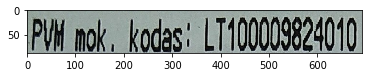

In [ ]:
for t,l,b,r in bboxes:
    text_im = im[ t:b , l:r ]
    plot(text_im)
    break

In [ ]:
from ocr.ocr_crnn_training import *
from ocr.ocr_inference import CrnnOcrPredictor
from ocr.ocr_attention_training import *
from ocr.ocr_inference import TesseractOcrPredictor, AttentionOcrPredictor

CNN output = h:1 c:512


In [ ]:
from ocr.ocr_crnn_training import *
from ocr.ocr_inference import CrnnOcrPredictor
from ocr.ocr_dataset_fontsynth import fontsynth_config, char_freq
crnn_ocr_predictor = CrnnOcrPredictor(model_name='crnn_ocr', use_gpu=False)

In [ ]:
from ocr.ocr_attention_training import *
from ocr.ocr_inference import AttentionOcrPredictor
attention_ocr_predictor = AttentionOcrPredictor(model_name='attention_ocr', use_gpu=False)

In [ ]:
from ocr.ocr_inference import TesseractOcrPredictor
tesseract_ocr_predictor = TesseractOcrPredictor()

In [ ]:
text = attention_ocr_predictor.image2text(tensor(text_im))
print(text)

PVM NOK, KODAS: LT100009824010


### BBox Results

In [ ]:
def read_gt_data(csv_path='images/X00016469670.txt', only_points=False):
    ''' returns [([4,2], str),...] '''
    out = []
    with open(csv_path, encoding="utf8") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for line in csv_reader:
            if len(line) > 8:
                x1, y1, x2, y2, x3, y3, x4, y4 = list(map(int, line[:8]))
                label = ','.join(line[8:])
                points = np.array([ [x1, y1], [x2, y2], [x3, y3], [x4, y4] ])
                if only_points: out.append(points)
                else: out.append([points, label])
    return out

In [ ]:
def read_submit_bbox_data(csv_path='images/X00016469670.txt'):
    ''' returns np.array w/ shape [N,4,2] '''
    out = []
    with open(csv_path, encoding="utf8") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for line in csv_reader:
            x1, y1, x2, y2, x3, y3, x4, y4 = list(map(int, line[:8]))
            points = np.array([ [x1, y1], [x2, y2], [x3, y3], [x4, y4] ])
            out.append(points)
    return out

In [ ]:
def poly2bbox(points, height=9999, width=9999):
    ''' [N,4,2] (ex: [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]) -> [t,l,b,r] '''
    _min, _max = np.min(points, axis=-2), np.max(points, axis=-2) # [N,2]
    _min = np.maximum(_min, 0) # [N,2]
    _max[:,0] = np.minimum(_max[:,0], width) # [N,2]
    _max[:,1] = np.minimum(_max[:,1], height) # [N,2]
    
    return np.stack([_min[:,1], _min[:,0], _max[:,1], _max[:,0]], axis=1)

In [ ]:
def calc_bbox_precision_recall(bbox_pred, bbox_true, iou_thresh=0.5):
    ''' [P,4], [T,4] (Preds, Trues)'''
    num_preds, num_trues = len(bbox_pred), len(bbox_true)

    ious = IoU(bbox_pred, bbox_true)
    is_overlaping = ious > iou_thresh
    
    correct = 0
    pred_idxes =list(range(len(bbox_pred)))
    for i_true in range(len(bbox_true)):
        i_overlap = check_overlap(i_true, pred_idxes, is_overlaping)
        if i_overlap is not None:
            pred_idxes.remove(i_overlap)
            correct += 1
            
    precision = correct / num_preds
    recall = correct / num_trues
    # print(precision, recall, correct, num_preds)
    return precision, recall

In [ ]:
def bbox_submit_vs_gt(main_dir, test_dir):

    p, r = 0, 0
    for fn in os.listdir(test_dir):
        true_poly = np.array(read_gt_data(os.path.join(main_dir, fn), only_points=True)) # [N,4,2]
        pred_poly = np.array(read_submit_bbox_data(os.path.join(test_dir, fn))) # [M,4,2]
        
        true_bbox = poly2bbox(true_poly) # [N,4]
        pred_bbox = poly2bbox(pred_poly) # [M,4]
        
        precision, recall = calc_bbox_precision_recall(tensor(pred_bbox), tensor(true_bbox))
        p += precision
        r += recall


    r /= len(os.listdir(test_dir))
    p /= len(os.listdir(test_dir))
    
    return p, r

In [ ]:
SUBMIT_DIR, IMAGES_DIR, GT_DIR = '../data/sroie2019/submit_bbox', '../data/sroie2019/test_img', '../data/sroie2019/test_gt'

In [ ]:
def do(fn, im2bbox):
    with open(os.path.join(SUBMIT_DIR, fn[:-3] + 'txt'), mode='w', encoding="utf8") as write_file:
        im = cv2.imread(os.path.join(IMAGES_DIR, fn[:-3] + 'jpg'))
        if im is None: print(os.path.join(IMAGES_DIR, fn[:-3] + 'jpg'))
        im_orig = im
        h_orig, w_orig, c = im.shape
        for i in range(1):
            bboxes = im2bbox(tensor(im))
            for t,l,b,r in bboxes:
                im[ t:b, l:r ] = 0
                t,l,b,r = list(map(int, [t,l,b,r]))
                t,l,b,r = list(map(str, [t,l,b,r]))
                write_file.write(','.join([l,t,r,t,r,b,l,b]) + '\n')

In [ ]:
bbox_predictor = TextBBoxPredictor(model_name='east_bbox_10x3', use_gpu=True)
im2bbox = partial(bbox_predictor.image2bboxes, offset=0)
for fn in tqdm(os.listdir(IMAGES_DIR), total=len(os.listdir(IMAGES_DIR))): do(fn, im2bbox)

In [ ]:
f1 = lambda p,r: 2 * (p * r) / (p + r)
p, r = bbox_submit_vs_gt(GT_DIR, SUBMIT_DIR)
print('precision:', p)
print('recall', r)
print('f1', f1(p,r))

precision: 0.9685779090095865
recall 0.958471828930838
f1 0.963498369172997


### OCR

In [ ]:
def read_data(csv_path='images/X00016469670.txt'):
    ''' returns [([4,2], str),...] '''
    out = []
    with open(csv_path, encoding="utf8") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for line in csv_reader:
            if len(line) > 8:
                x1, y1, x2, y2, x3, y3, x4, y4 = list(map(int, line[:8]))
                label = ','.join(line[8:])
                points = np.array([ [x1, y1], [x2, y2], [x3, y3], [x4, y4] ])
                out.append([points, label])
    return out

In [ ]:
def read_data(csv_path='images/X00016469670.txt'):
    ''' returns [([4,2], str),...] '''
    out = []
    with open(csv_path, encoding="utf8") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for line in csv_reader:
            if len(line) > 8:
                x1, y1, x2, y2, x3, y3, x4, y4 = list(map(int, line[:8]))
                label = ','.join(line[8:])
                points = np.array([ [x1, y1], [x2, y2], [x3, y3], [x4, y4] ])
                out.append([points, label])
    return out


def read_preds(fpath, f=lambda x:x):
    with open(fpath, encoding="utf8") as read_file:
        lines = read_file.readlines()
        words = [l.replace('\n', '') for l in lines]
        words = [f(w) for w in words]
    return words


def read_trues(fpath, f=lambda x:x):
    gts = read_data(fpath)
    true_words = []
    for points, label in gts:
        label = label.replace('*', '')
        words = label.split(' ')
        words = list(filter(lambda w: w!= '', words))
        words = [f(w) for w in words]
        true_words.extend(words)
    return true_words


def calc_precision_recall(true_words, pred_words):
    num_preds, num_trues = len(pred_words), len(true_words)

    correct = 0
    for true_word in true_words:
        if true_word in pred_words:
            pred_words.remove(true_word)
            correct += 1
            continue
    
    precision = correct / num_preds if num_preds > 0 else 0
    recall = correct / num_trues if num_trues > 0 else 0
    # print(precision, recall, correct, num_preds)
    return precision, recall

In [ ]:
def word_fn(word):
    return word.upper()

def text_submit_vs_gt(main_dir, test_dir):

    p, r = 0, 0
    for fn in os.listdir(test_dir):
        true_words = read_trues(os.path.join(main_dir, fn), word_fn)
        pred_words = read_preds(os.path.join(test_dir, fn), word_fn)
        precision, recall = calc_precision_recall(true_words, pred_words)
        p += precision
        r += recall


    r /= len(os.listdir(test_dir))
    p /= len(os.listdir(test_dir))
    
    return p, r

In [ ]:
PAD = 0
global errors
errors = 0
def do(fn, im2text):
    global errors
    with open(os.path.join(main_dir, fn), mode='w', encoding="utf8") as write_file:
        im = cv2.imread(os.path.join(img_dir, fn[:-3] + 'jpg'))
        
        gt = read_data(os.path.join(test_dir, fn))
        for points, label in gt:
            points = np.array(points) # [4,2]
            _min, _max = np.min(points, axis=0), np.max(points, axis=0)
            _min -= PAD
            _max += PAD
            _min[0], _min[1] = max(_min[0], 0), max(_min[1], 0)
            _max[0], _max[1] = min(_max[0], im.shape[1]), min(_max[1], im.shape[0])
            im_line = im[ _min[1]:_max[1], _min[0]:_max[0] ]
            try: text = im2text(tensor(im_line))
            except:
                errors += 1
                text = ''
            f = lambda x: x!='' and x!=' '
            for line in filter(f, text.split('\n')):
                for word in line.split(' '):
                    if word != '':
                        write_file.write(word.upper() + '\n')

In [ ]:
main_dir, test_dir, img_dir = '../data/sroie2019/submit_ocr', '../data/sroie2019/test_gt', '../data/sroie2019/test_img'

In [ ]:
from ocr.ocr_crnn_training import *
from ocr.ocr_inference import CrnnOcrPredictor
from ocr.ocr_dataset_fontsynth import fontsynth_config, char_freq
text_predictor = CrnnOcrPredictor(model_name='crnn_ocr', use_gpu=True)

In [ ]:
from ocr.ocr_inference import TesseractOcrPredictor
text_predictor = TesseractOcrPredictor()

In [ ]:
from ocr.ocr_attention_training import *
from ocr.ocr_inference import AttentionOcrPredictor
text_predictor = AttentionOcrPredictor(model_name='attention_ocr', use_gpu=True)

In [ ]:
for fn in tqdm(os.listdir(test_dir), total=len(os.listdir(test_dir))): do(fn, im2text=text_predictor.image2text)
print(errors)


0


In [ ]:
f1 = lambda p,r: 2 * (p * r) / (p + r)
p, r = text_submit_vs_gt(test_dir, main_dir)
print('precision:', p)
print('recall', r)
print('f1', f1(p,r))

precision: 0.9175833621706564
recall 0.9128267652751496
f1 0.9151988833555397
